In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install tensorflow_hub

In [ ]:
# import tensorflow_hub as hub

In [ ]:
import keras
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [ ]:
#pip install opencv-python

In [ ]:
class_names = ['diseased cotton leaf','diseased cotton plant','fresh cotton leaf','fresh cotton plant']
class_labels ={'diseased cotton leaf':0,'diseased cotton plant':1,'fresh cotton leaf':2,'fresh cotton plant':3}
img_size = (224,224)

In [ ]:
paths = ['/content/drive/My Drive/Cotton Disease/train','/content/drive/My Drive/Cotton Disease/test']


In [ ]:
os.listdir('/content/drive/My Drive/Cotton Disease/train')

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [ ]:
os.listdir(os.path.join(paths[0],'diseased cotton leaf'))[:5]

['dis_leaf (10)_iaip.jpg',
 'dis_leaf (1)_iaip.jpg',
 'dis_leaf (104)_iaip.jpg',
 'dis_leaf (102)_iaip.jpg',
 'dis_leaf (103)_iaip.jpg']

In [ ]:
## preprocess the image

def load_data(paths):
    output = []
    
    ## iterate thru test and train
    for path in paths:
        
        images = []
        labels = []
        print('Loading Started for',path)
        
        #iterate thru each folder 
        for folder in os.listdir(path):
            label = class_labels[folder]
            
            # iterate thru each image
            
            for file in tqdm(os.listdir(os.path.join(path,folder))):
            
                # path of the file
                img_path = os.path.join(os.path.join(path,folder),file)
                # open and resize the image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,img_size)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images,dtype='float32')
        labels = np.array(labels,dtype='int32')
        
        output.append((images,labels))
    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels)=load_data(paths)

  0%|          | 0/288 [00:00<?, ?it/s]

Loading Started for /content/drive/My Drive/Cotton Disease/train


100%|██████████| 421/421 [02:22<00:00,  2.95it/s]


Loading Started for /content/drive/My Drive/Cotton Disease/test


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


In [ ]:
train_images.shape, test_images.shape

((1951, 224, 224, 3), (106, 224, 224, 3))

In [ ]:
train_images,train_labels = shuffle(train_images,train_labels,random_state=0)

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0


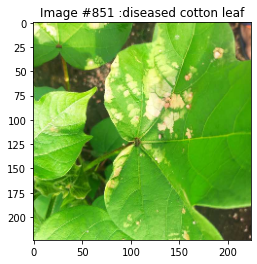

In [ ]:
index = np.random.randint(0,1951)
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{} :'.format(index) + class_names[train_labels[index]])
plt.show()

## TRANFER LEARNING

In [ ]:
## Imagenet is an image classification problem where there are 1000 classes. There are multiple models to do this task. 
###Eg: VGG16, Resnet, Mobilenet, 

# creating an object of vgg16 excluding the last layer
vgg = VGG16(input_shape=(224,224) + (3,), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
layers = vgg.layers  ## include top = False, does not include the last fully connected layers
layers

In [ ]:
# no need to train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# ## Lets see the number of layers with include = True

# vgg1 = VGG16(input_shape=(224,224) + (3,), weights='imagenet', include_top=True)

In [ ]:
# vgg1.layers  ## includes the normal fully connected layers

In [ ]:
# vgg1.output

In [ ]:
vgg.output  # this shows the last layer of our vgg model. SInce the actual output layre is omitted, vgg.output gives the last pooling layer

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
## Flatten this layer to pass it thru our fully connected layer

flat = Flatten()(vgg.output)
flat

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [ ]:
## adding our own output layer with 4 neurons over the flat layer

output = Dense(4,activation='softmax')(flat)

In [ ]:
output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense')>

In [ ]:
## creating a model out of this

model = Model(inputs=vgg.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_images[0].shape

(224, 224, 3)

In [ ]:
history = model.fit(train_images,train_labels,batch_size = 128, epochs=5,validation_split=0.15)

Epoch 1/5
13/13 [==============================] - 85s 3s/step - loss: 1.5517 - accuracy: 0.4412 - val_loss: 0.5456 - val_accuracy: 0.7782
Epoch 2/5
13/13 [==============================] - 9s 664ms/step - loss: 0.4267 - accuracy: 0.8382 - val_loss: 0.3421 - val_accuracy: 0.8840
Epoch 3/5
13/13 [==============================] - 9s 669ms/step - loss: 0.2387 - accuracy: 0.9274 - val_loss: 0.2950 - val_accuracy: 0.9010
Epoch 4/5
13/13 [==============================] - 9s 686ms/step - loss: 0.1631 - accuracy: 0.9621 - val_loss: 0.2326 - val_accuracy: 0.9249
Epoch 5/5
13/13 [==============================] - 9s 693ms/step - loss: 0.1158 - accuracy: 0.9814 - val_loss: 0.2207 - val_accuracy: 0.9215


In [ ]:
#for layers in model.layers:
#    print(layers.get_weights())


In [ ]:
## evaluate the model

accuracy = model.evaluate(test_images,test_labels)
accuracy  ## without using VGG16 the accuracy was just 66% 

4/4 [==============================] - 9s 919ms/step - loss: 0.1998 - accuracy: 0.9151


[0.19983932375907898, 0.9150943160057068]

In [ ]:
# Increase the number of layers, neurons or epochs to get better accuarcy

# predict

pred = model.predict(test_images)
pred ## for each image this will have 4 probabilites as we have used softmax as the function. We will be take the max of each image

array([[5.51071823e-01, 3.23441287e-04, 4.48565871e-01, 3.88880544e-05],
       [8.85039508e-01, 1.48097239e-03, 1.11221634e-01, 2.25788704e-03],
       [9.86066282e-01, 2.00385973e-03, 1.15608927e-02, 3.68980283e-04],
       [9.50422764e-01, 8.80025545e-05, 4.94284406e-02, 6.07679649e-05],
       [9.80982840e-01, 1.59621320e-03, 1.61618683e-02, 1.25905732e-03],
       [9.49301720e-01, 4.26173756e-05, 5.05395234e-02, 1.16121781e-04],
       [9.96064007e-01, 3.30812205e-03, 6.20044011e-04, 7.82566531e-06],
       [9.73131776e-01, 1.15501108e-02, 1.38987433e-02, 1.41941826e-03],
       [9.99063551e-01, 5.61948342e-04, 3.48611298e-04, 2.58978598e-05],
       [9.74126637e-01, 6.43050735e-05, 2.57378295e-02, 7.11142347e-05],
       [9.94446635e-01, 3.41657549e-04, 5.18653961e-03, 2.51850161e-05],
       [9.97758746e-01, 3.61805112e-04, 1.81788555e-03, 6.15639947e-05],
       [9.62028742e-01, 1.03098064e-04, 3.78626846e-02, 5.44796603e-06],
       [7.96046078e-01, 2.98353320e-04, 2.03572258e

In [ ]:
np.argmax(pred,axis = 1) # taking argmax xoz we want the label of highest prob in each image

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1])

In [ ]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
labels = np.argmax(pred,axis = 1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(labels,test_labels))
confusion_matrix(test_labels,labels)

0.9150943396226415


array([[23,  0,  2,  0],
       [ 0, 26,  1,  1],
       [ 0,  0, 26,  0],
       [ 0,  5,  0, 22]])

In [ ]:
## prediction of image one

labels[1]

0

In [ ]:
test_images[1]


array([[[0.24313726, 0.38039216, 0.16862746],
        [0.24313726, 0.38039216, 0.16862746],
        [0.23529412, 0.37254903, 0.14509805],
        ...,
        [0.34901962, 0.5529412 , 0.23137255],
        [0.34117648, 0.54509807, 0.22352941],
        [0.33333334, 0.5372549 , 0.21568628]],

       [[0.24313726, 0.38039216, 0.16862746],
        [0.24313726, 0.38039216, 0.16862746],
        [0.23529412, 0.37254903, 0.14509805],
        ...,
        [0.34901962, 0.5529412 , 0.23137255],
        [0.34117648, 0.54509807, 0.22352941],
        [0.33333334, 0.5372549 , 0.21568628]],

       [[0.23921569, 0.3764706 , 0.16470589],
        [0.23921569, 0.3764706 , 0.16470589],
        [0.23529412, 0.37254903, 0.14509805],
        ...,
        [0.34901962, 0.5529412 , 0.23137255],
        [0.34117648, 0.54509807, 0.22352941],
        [0.32941177, 0.53333336, 0.21176471]],

       ...,

       [[0.24705882, 0.19607843, 0.13725491],
        [0.23529412, 0.18431373, 0.12156863],
        [0.23137255, 0

Text(0.5, 1.0, 'diseased cotton leaf')

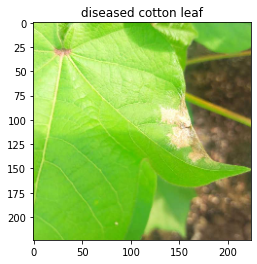

In [ ]:
# Actual 

plt.imshow(test_images[0])
plt.title(class_names[test_labels[0]])

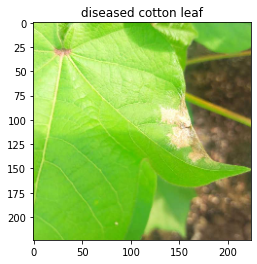

In [ ]:
# predicted
plt.figure()
plt.imshow(test_images[0])
plt.title(class_names[labels[0]])
plt.show()

Text(0.5, 1.0, 'diseased cotton leaf')

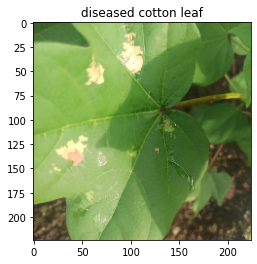

In [ ]:
# Actual 

plt.imshow(test_images[1])
plt.title(class_names[test_labels[1]])

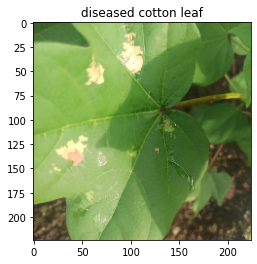

In [ ]:
# predicted

plt.imshow(test_images[1])
plt.title(class_names[labels[1]])
plt.show()